In [22]:
import torch
import torchvision
import torch.nn as nn                           # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim                     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F                 # All functions that don't have any parameters
from torch.utils.data import DataLoader         # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets         # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import ruptures as rpt
import h5py

In [5]:
def to_string(x):
    decode_str = ''.join(chr(c[0]) for c in x)
    return decode_str

In [13]:
file_path = r"C:\AIEEE\DATASET\CARDRF\LOS\Train\UAV\DJI_M600\FLYING\DJIM600_10M_FLYING_0000100006.mat"

with h5py.File(file_path, 'r') as f:
    print("최상위 키 목록:", list(f.keys()))

    # 각 키 내부 구조 살펴보기
    for key in f.keys():
        print(f"\n[{key}] 내부 구조:")
        try:
            obj = f[key]
            if isinstance(obj, h5py.Group):
                print("  Group 하위 키:", list(obj.keys()))
            elif isinstance(obj, h5py.Dataset):
                print("  Dataset shape:", obj.shape)
        except Exception as e:
            print("  오류 발생:", e)
    label = f['/Frame/Model'][:]
    serial = f['/Frame/Serial'][:]
    print(to_string(label))
    print(to_string(serial))

최상위 키 목록: ['#refs#', 'Channel_1', 'Frame']

[#refs#] 내부 구조:
  Group 하위 키: ['a']

[Channel_1] 내부 구조:
  Group 하위 키: ['Data', 'NumPoints', 'NumSegments', 'WaveformType', 'XData', 'XDispOrigin', 'XDispRange', 'XInc', 'XOrg', 'XUnits', 'YDispOrigin', 'YDispRange', 'YInc', 'YOrg', 'YUnits']

[Frame] 내부 구조:
  Group 하위 키: ['Date', 'Model', 'Serial']
MSOS604A
MY55510227


X축 단위: Second
y축 단위: Volt


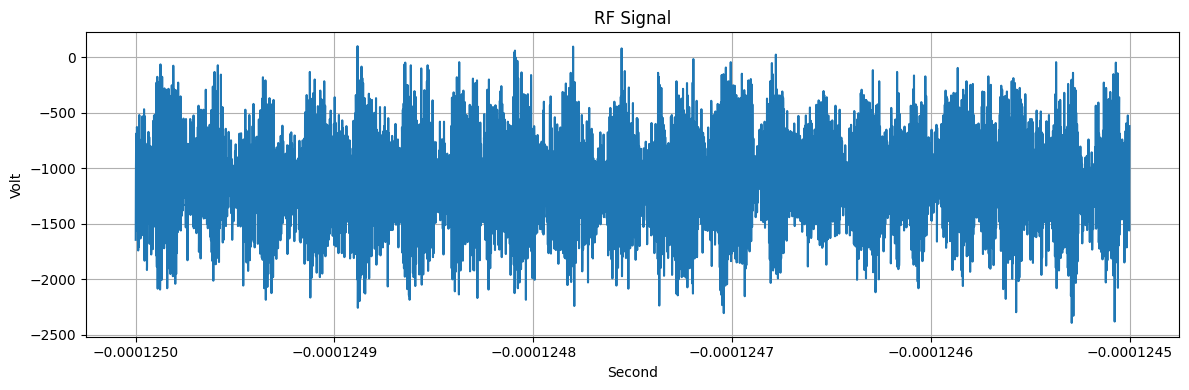

In [9]:
import matplotlib.pyplot as plt

file_path = r"C:\AIEEE\DATASET\CARDRF\LOS\Test\UAV\BEEBEERUN\FLYING\BEEBEERUN_0000100002.mat"

def makeDF(file_path):
    with h5py.File(file_path, 'r') as f:

        
        # Y축 신호 데이터
        y = f['/Channel_1/Data'][0]  # shape: (5000000,)
    
        # X축 설정 값들
        x_origin = f['/Channel_1/XOrg'][0][0]      # float64
        x_inc = f['/Channel_1/XInc'][0][0]         # float64
        x_disp_range = f['/Channel_1/XDispRange'][0][0]  # float64
    
        # X축 시간 벡터 생성
        x = np.arange(len(y)) * x_inc + x_origin
    
        # X 단위 추출
        x_unit_raw = f['/Channel_1/XUnits'][:]  # 예: (6, 1)
        x_unit = ''.join(chr(c[0]) for c in x_unit_raw)
        print("X축 단위:", x_unit)
        y_unit_raw = f['/Channel_1/YUnits'][:]
        y_unit = ''.join(chr(c[0]) for c in y_unit_raw)
        print("y축 단위:",y_unit)

        dic = {'x': [x], 'y':[y], 'x_unit':[x_unit], 'y_unit':[y_unit]}
        df = pd.DataFrame(dic)
    # 시각화 (앞부분만)
    plt.figure(figsize=(12, 4))
    plt.plot(x[:10000], y[:10000])
    plt.title("RF Signal")
    plt.xlabel(x_unit)
    plt.ylabel(y_unit)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df

df = makeDF(file_path)

In [20]:
df['y']

0    [-1644, -1208, -1032, -924, -688, -828, -1328,...
Name: y, dtype: object

In [48]:


file_path = r"C:\AIEEE\DATASET\CARDRF\LOS\Test\UAV\BEEBEERUN\FLYING\BEEBEERUN_0000100002.mat"
f = h5py.File(file_path, 'r')

data = np.array(f['/Channel_1/Data'], dtype=np.float64)
x_inc = np.array(f['/Channel_1/XInc'][0][0], dtype=np.float64) # array(5.e-11)
x_org = np.array(f['/Channel_1/XOrg'][0][0], dtype=np.float64) # array(-0.000125)

y_inc = np.array(f['/Channel_1/YInc'], dtype=np.float64)

timestem = np.arange(len(y)) * x_org + x_inc

In [49]:
x_org, x_inc, y_inc

(array(-0.000125), array(5.e-11), array([[6.58411815e-06]]))

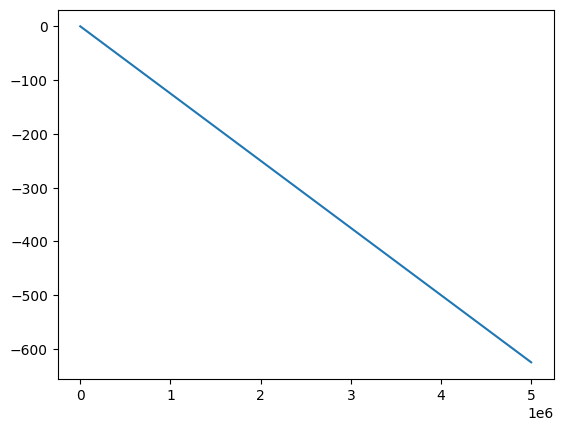

In [45]:
plt.plot(timestem)

In [54]:
df = pd.read_csv(r"C:\AIEEE\DATASET\Processed_CardRF\Test\UAV\DJI_M600.csv")

In [58]:
df

,23840,-4612,-30768,-32736,-26992,184,26908,30720,27232,-32,...,-23104,-32736.198,-32736.199,-9572,20008,30720.194,30720.195,Non_Control,DJI_M600,DJI_M600_FLYING
0,30720,9208,-20684,-32736,-32736,-12196,17704,30720,30720,11680,...,-32736,-32736,-26976,4736,30720,30720,25140,Non_Control,DJI_M600,DJI_M600_FLYING
1,25140,-6496,-32736,-32736,-28000,2280,30720,30720,26552,-3684,...,-32736,-14852,15124,30720,30720,15640,-15044,Non_Control,DJI_M600,DJI_M600_FLYING
2,-15044,-32736,-32736,-17800,12420,30720,30720,19472,-11784,-32736,...,1772,24612,30720,22508,-2568,-26720,-32736,Non_Control,DJI_M600,DJI_M600_FLYING
3,-32736,-24752,-928,22692,30720,24176,480,-24180,-32736,-26112,...,5648,9296,7244,716,-7168,-11716,-9676,Non_Control,DJI_M600,DJI_M600_FLYING
4,-9676,-2656,4828,9140,8076,1620,-6576,-11372,-10184,-3960,...,6708,5516,496,-5528,-8920,-7880,-3200,Non_Control,DJI_M600,DJI_M600_FLYING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,8832,-21004,-32736,-32736,-12296,17652,30720,30720,11872,-18240,...,-32736,-16896,13320,30720,30720,17600,-13352,Non_Control,DJI_M600,DJI_M600_FLYING
14995,-13352,-32736,-32736,-20680,8704,30720,30720,21644,-8728,-32736,...,-30240,-8772,16860,30720,30116,8788,-18276,Non_Control,DJI_M600,DJI_M600_FLYING
14996,-18276,-32736,-32004,-11944,14032,30720,30720,12176,-14784,-32736,...,-32736,-18976,9452,30720,30720,19512,-9496,Non_Control,DJI_M600,DJI_M600_FLYING
14997,-9496,-32736,-32736,-22732,5096,29612,30720,23268,-5108,-31084,...,-18980,11444,30720,30720,19888,-11096,-32736,Non_Control,DJI_M600,DJI_M600_FLYING


In [57]:
df.shape, df.columns

((14999, 1027),
 Index(['23840', '-4612', '-30768', '-32736', '-26992', '184', '26908', '30720',
        '27232', '-32',
        ...
        '-23104', '-32736.198', '-32736.199', '-9572', '20008', '30720.194',
        '30720.195', 'Non_Control', 'DJI_M600', 'DJI_M600_FLYING'],
       dtype='object', length=1027))